1. 1. Elección de datos y breve descripción de su naturaleza (¿de qué tratan?).

- Introducción.

- Objetivos generales:

Poner en práctica y desarrollar la capacidad de sacar valor a los datos a partir de las conceptos y herramientas de estadística descriptivas que hemos visto en clase. Poder calcular generalidades de los datos a partir de una muestra 

- Objetivos particulares:

Aprender y mostrar lo aprendido, haciendo.

- Dataset elegido:

Nuestro dataset fifa_players.csv obtenido en Kaggle, recoge ~ 17,000 entradas de futbolistas (hombres), con 51 características, como nombre, edad, peso, habilidades, puntuación global o posición en el campo, entre otras.

Sobre esta muestra de ~17,000 entradas vamos a realizar una caracterización de la distribución de las variables y un análisis de variación (ANOVA) a partir del cual trataremos de inferir conclusiones sobre la población (total de futbolistas hombres en el mundo).

Instalamos los módulos de Python que necesitaremos e importamos las librerías necesarias sin las cuales no podemos abarcar nuestro análisis.

In [ ]:
!pip install distfit
!pip install pycountry_convert

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import math
from distfit import distfit
from itertools import combinations
import pycountry_convert as pc
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy.stats import boxcox

Importamos nuestro dataset para trabajar a partir de él.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
fifa_all = pd.read_csv('/content/drive/MyDrive/fifa_players.csv')


In [9]:
# Para trabajar en local:

fifa_all=pd.read_csv('C:\\Users\\josan\\Documents\\GitHub\\EDEM_MDA2324\\Alumnos\\ES\\Josan_Rodrigo_Cortes\\Estadística\\trabajodefinitivo\\fifa_players.csv')

2. Descriptiva univariante y bivariante de los datos teniendo en cuenta su tipo.

En una primera aproximación a nuestros datos vamos a ver que contienen, el numero de observaciones que componen nuestro dataframe y las diferentes variables. A continuación con un head vemos las primeras filas de nuestro fichero csv en un dataframe de pandas. 

In [12]:
fifa_all.head(5)

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


Puesto que mediante el head no podemos ver todas las variables que contiene nuestro dataframe, las listamos a continuación utilizando el método columns. Obtenemos tambien el total de ellas y vemos que disponemos de 51

In [18]:
fifa_all.columns

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

In [17]:

print("Número de variables:", len(fifa_all.columns))

Número de variables: 51


Utilizamos la función info para saber el número de observaciones que contiene cada variable. Este método nos va ayudará más tarde a ver que variables contienen datos nulos o faltantes, etc..

In [22]:
fifa_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null 

2.1. Tipos de variables

Tras introducir brevemente las carácterísticas de nuestros datos y ante la cantidad de variables presentes, vamos a mostrarlas de manera gráfica para poner en contexto que variables cuantitavias y cualitativas tenemos.
Vemos que hay un 17,6% de variables categóricas, un 13.7 de variables cuantitativas continuas y un 68.6% de variables cuantitavias discretas. 

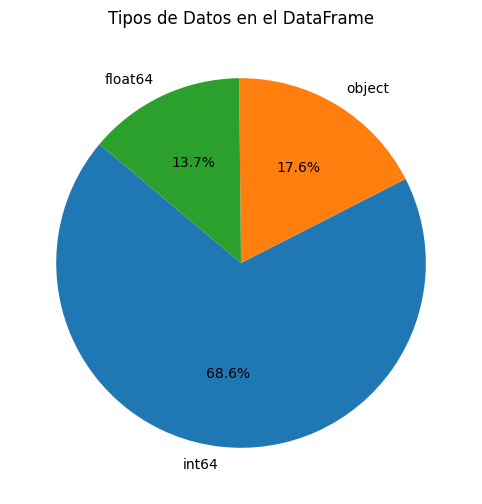

In [24]:
# Crear un DataFrame que contenga los tipos de datos de cada columna
data_types = pd.DataFrame(fifa_all.dtypes, columns=['Tipo de Datos'])

# Contar el número de variables de cada tipo de datos
data_type_counts = data_types['Tipo de Datos'].value_counts()

# Crear el diagrama de pastel
plt.figure(figsize=(8, 6))
data_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Tipos de Datos en el DataFrame')
plt.ylabel('')  # Eliminar la etiqueta del eje y
plt.show()

Para seguir profundizando en nuestras variables, vamos a mostrar un histograma de cada variable cuantitavia. Por su aparente normalidad pasaremos a partir de ahora a centrar nuestro análisis en:

- Overal_rating
- Potential

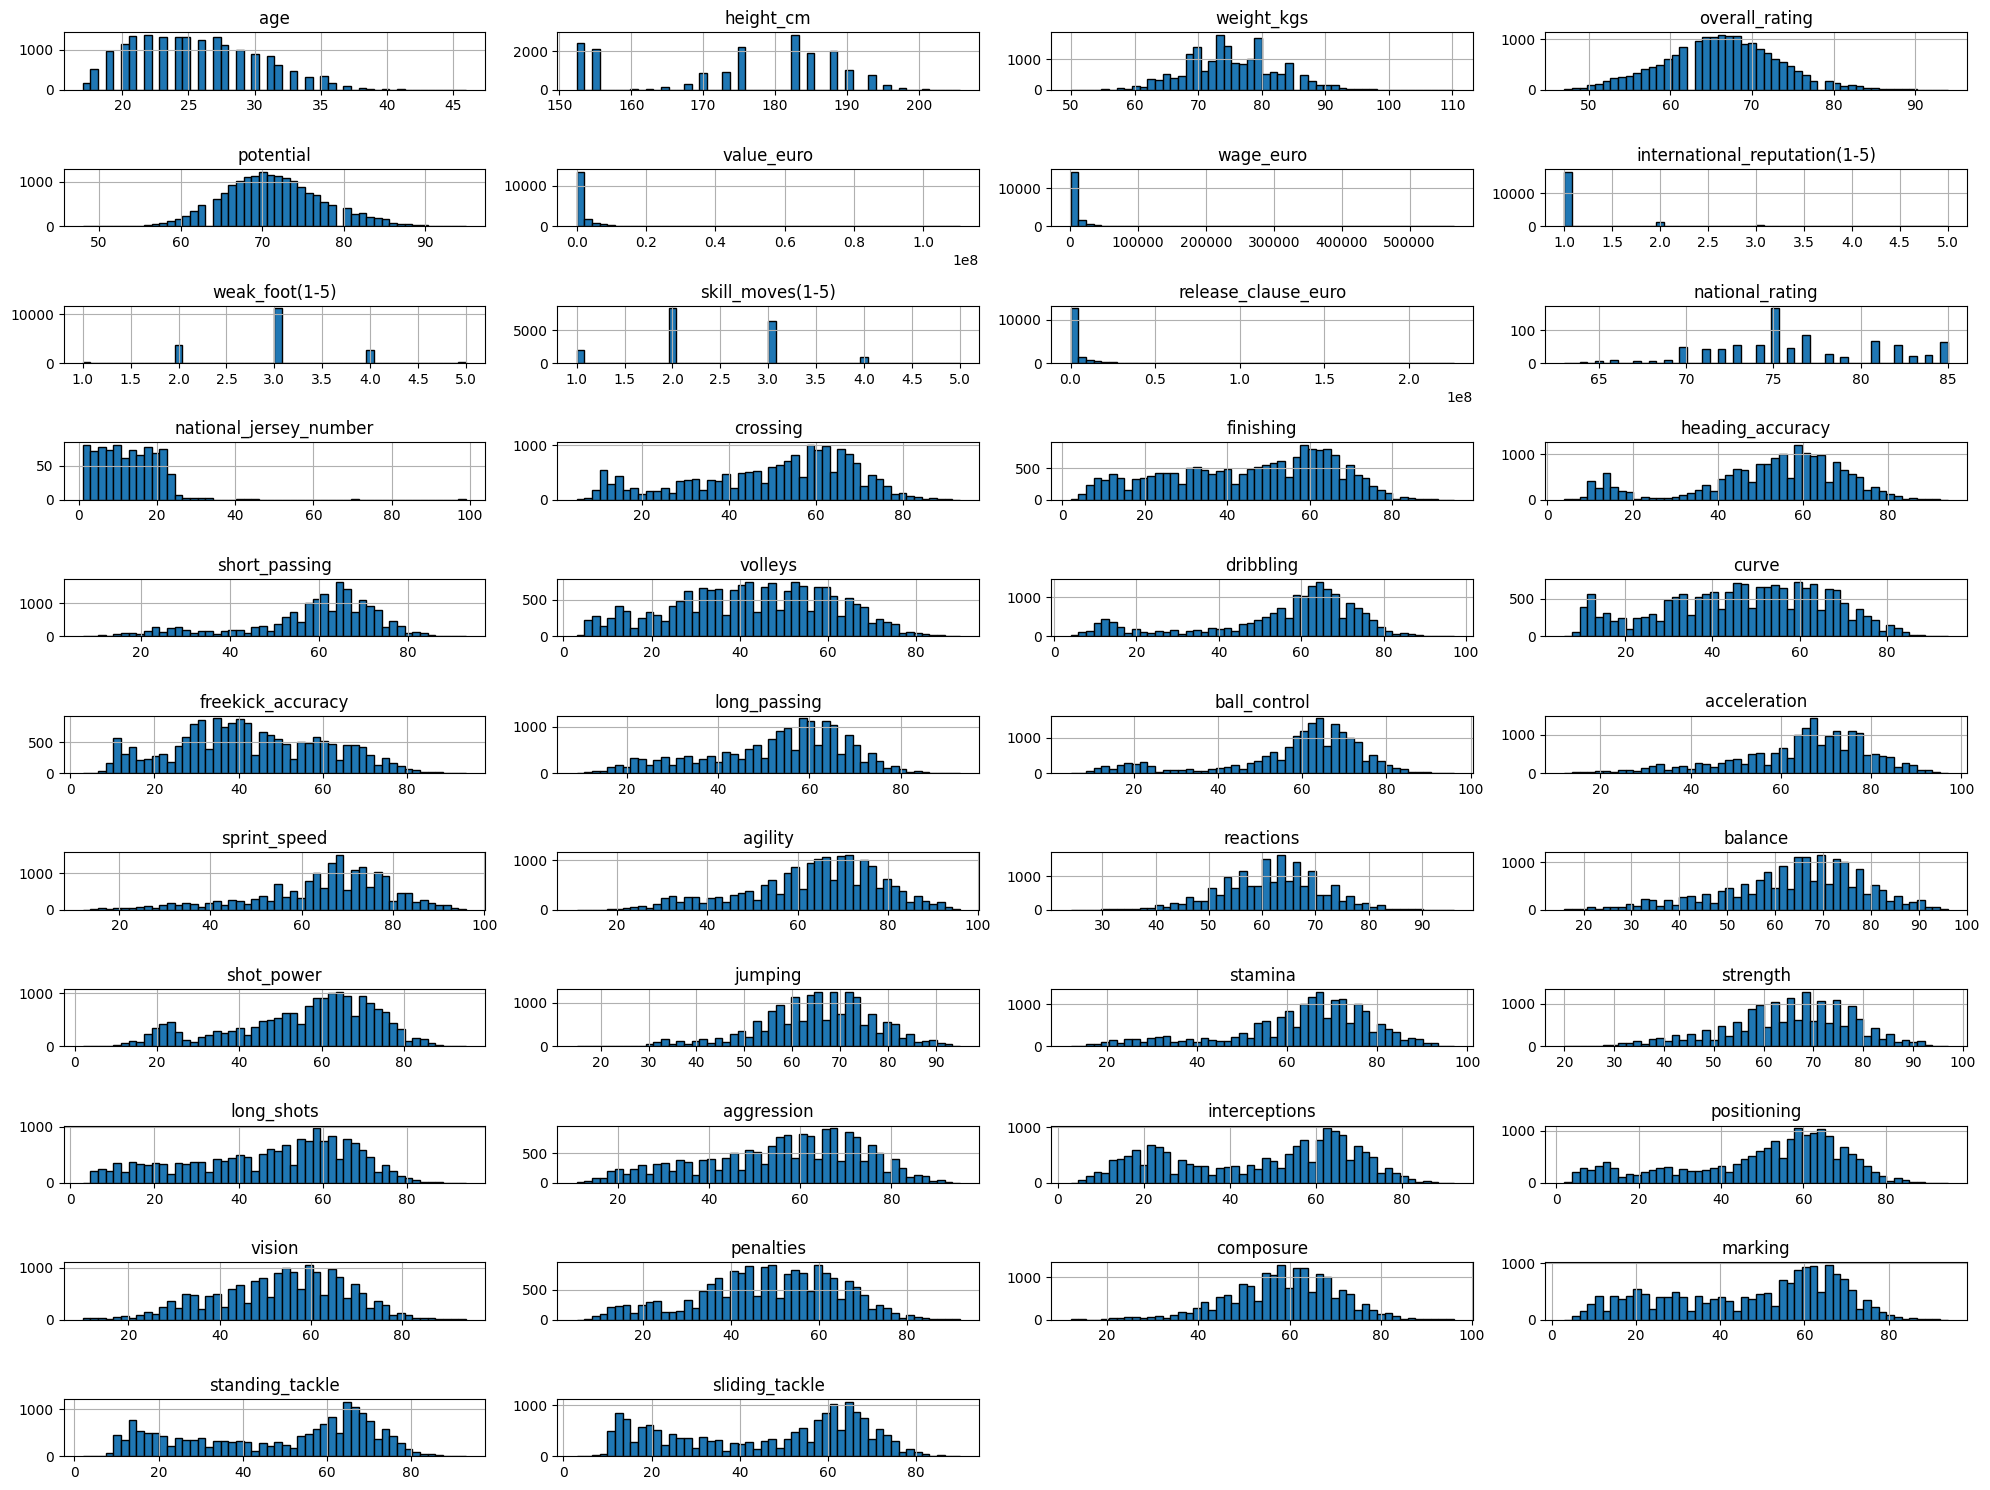

In [7]:
columns = fifa_all.columns

fifa_all.hist(figsize=(20, 15), bins=50, layout=(-1, 4), edgecolor='black')
plt.tight_layout()
plt.show()

Vamos a analizar ahora que variables cualitativas tenemos y que grado de interés pueden generar para nuestro análisis.

In [29]:
import matplotlib.pyplot as plt

columnas_cualitativas = fifa_all.select_dtypes(include=['object']).columns
print(columnas_cualitativas)


Index(['name', 'full_name', 'birth_date', 'positions', 'nationality',
       'preferred_foot', 'body_type', 'national_team',
       'national_team_position'],
      dtype='object')


La celda anterior nos lista las variables cualitativas y descartamos directamente 'name', 'full_name', 'birth_date' por ser variables carentes de significación para nuestro análisis, así como 'preferred_foot', 'body_type',national_team', 'national_team_position', que aunque podrían ser analizadas, nos parecen menos interesantes de analizar que 'positions', 'nationality'.

Así pués, nos centraremos a partir de ahora en las variables categoricas 'positions', 'nationality'.

Vamos a analizar la distribución de frecuencias de cada una:


In [8]:
frequency_of_nationalities = fifa_all['nationality'].value_counts()
frequency_of_nationalities

England                 1658
Germany                 1199
Spain                   1070
France                   925
Argentina                904
                        ... 
Papua New Guinea           1
South Sudan                1
Malta                      1
Yemen                      1
United Arab Emirates       1
Name: nationality, Length: 160, dtype: int64

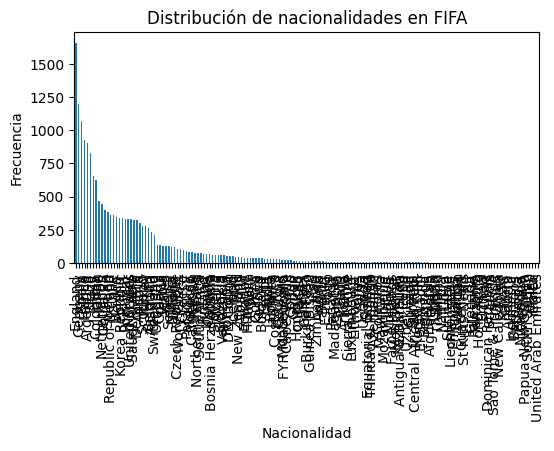

In [34]:
# Crear el gráfico de barras
plt.figure(figsize=(6, 3))
frequency_of_nationalities.plot(kind='bar')
plt.title('Distribución de nacionalidades en FIFA')
plt.xlabel('Nacionalidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()


In [36]:
frequency_of_positions = fifa_all['positions'].value_counts()
frequency_of_positions

CB              2243
GK              2065
ST              1747
CM               764
CDM,CM           709
                ... 
LB,LM,CB           1
CF,CM,ST           1
CB,ST              1
RB,ST              1
CAM,CM,RW,RM       1
Name: positions, Length: 890, dtype: int64

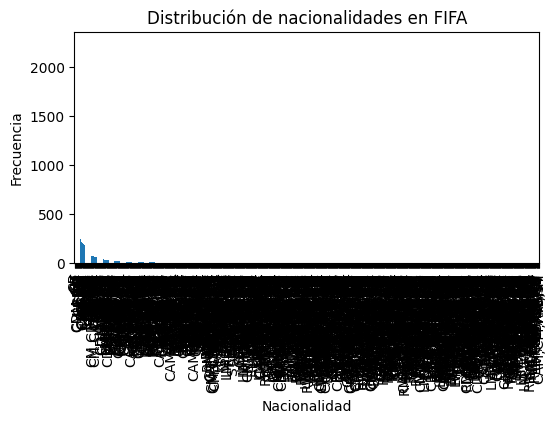

In [38]:
# Crear el gráfico de barras
plt.figure(figsize=(6, 3))
frequency_of_positions.plot(kind='bar')
plt.title('Distribución de nacionalidades en FIFA')
plt.xlabel('Nacionalidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()


Por la gran dispersión de las dos variables categoricas elegídas, decidimos, agrupar los nacionalidades por continentes y tomar la primera posición del listado de posiciones de cada jugador como la posición dominante del mismo para simplificar nuestro analisis. Tambien decidimos traducir el nombre de la posición para mayor claridad en conclusiones posteriores y eliminar los valores nulos.

In [42]:
# Group by positions
# Note: Since players can have multiple positions, here we consider just their primary position.
fifa_all['primary_position'] = fifa_all['positions'].apply(lambda x: x.split(',')[0])

# Renaming entries in column 'primary_position'
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'GK': 'PORTERO'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CAM': 'MEDIO OF'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CM': 'CENTROCAM.'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LW': 'EXT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RW': 'EXT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CB': 'DEF CENT'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'ST': 'ATAC'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CF': 'DEL CENT'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CDM': 'CENT DEF'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LB': 'LAT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RB': 'LAT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LM': 'CENT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RM': 'CENT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LWB': 'INT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RWB': 'INT DER'})

# Definir una función para obtener el continente de un país
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

# Aplicar la función a la columna 'nationality' para obtener el continente correspondiente
fifa_all['continent'] = fifa_all['nationality'].apply(get_continent)

# Ahora, fifa_all contiene una nueva columna 'continent' que indica el continente al que pertenece cada país

fifa_all = fifa_all.dropna(subset=['continent'])
fifa_all.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,primary_position,continent
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,22,94,94,75,96,33,28,26,DEL CENT,South America
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,56,84,91,67,88,59,57,22,MEDIO OF,Europe
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,64,82,88,82,87,63,67,67,CENTROCAM.,Europe
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,26,83,87,61,83,51,24,22,EXT IZQ,Europe
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,88,24,49,33,80,91,88,87,DEF CENT,Africa


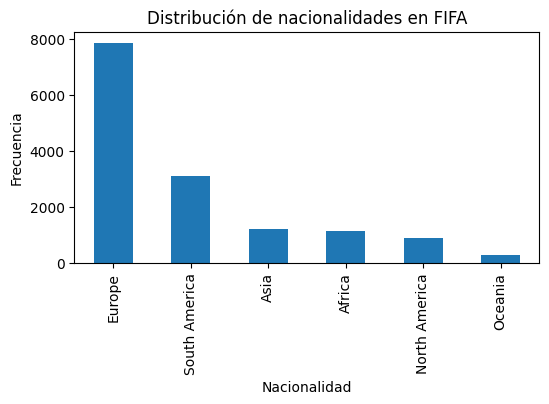

In [44]:
import matplotlib.pyplot as plt

# Obtener la frecuencia de cada nacionalidad
frequency_of_primary_position = fifa_all['continent'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(6, 3))
frequency_of_primary_position.plot(kind='bar')
plt.title('Distribución de nacionalidades en FIFA')
plt.xlabel('Nacionalidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()


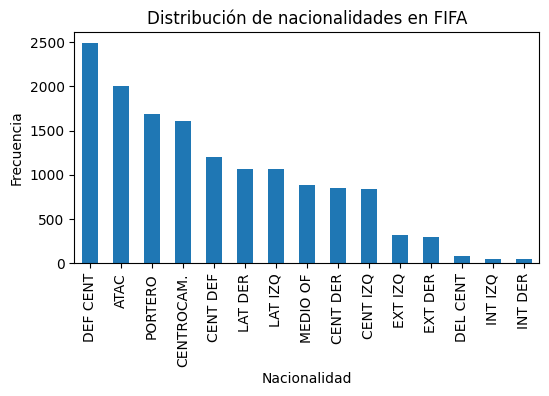

In [45]:

# Obtener la frecuencia de cada nacionalidad
frequency_of_primary_position = fifa_all['primary_position'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(6, 3))
frequency_of_primary_position.plot(kind='bar')
plt.title('Distribución de nacionalidades en FIFA')
plt.xlabel('Nacionalidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

De los dos gráficos anteriores, concluimos que tienen sentido agrupar las nacionalidades por continentes y clarificar las posiciciones en una sola.

2.2 Medidas descriptivas univariantes, de posición y dispersión.
Analizamos con describe los medidas descriptivas univariantes de las dos variables continuas elegidas con el siguiente resultado:

In [9]:
columns_to_analize=['overall_rating','potential']
fifa_all[columns_to_analize].describe()

,overall_rating,potential
count,14496.000000,14496.000000
mean,66.955160,72.011038
std,6.849744,5.949449
min,47.000000,50.000000
25%,63.000000,68.000000
50%,67.000000,72.000000
75%,71.000000,76.000000
max,94.000000,95.000000


Aqui faltaria un histograma + density de las dos continuas y otros dos de las dos variables

Seria muy chulo superponer una normal y una t student para continuar el análisis

Hablar de la normalidad de las dos variables

Metemos el boxplot o bigotes aquí?



Podemos ver de manera gráfica los datos anteriores con un boxplot, o diagrama de bigotes en el que se muestra el rango intercuartílico delimitado por el primer y el tercer cuartil, bordes de la caja, la mediana de la muestra, y los valores extremos o outlayers.
Podemos meter tambien aquí un grafico de violin


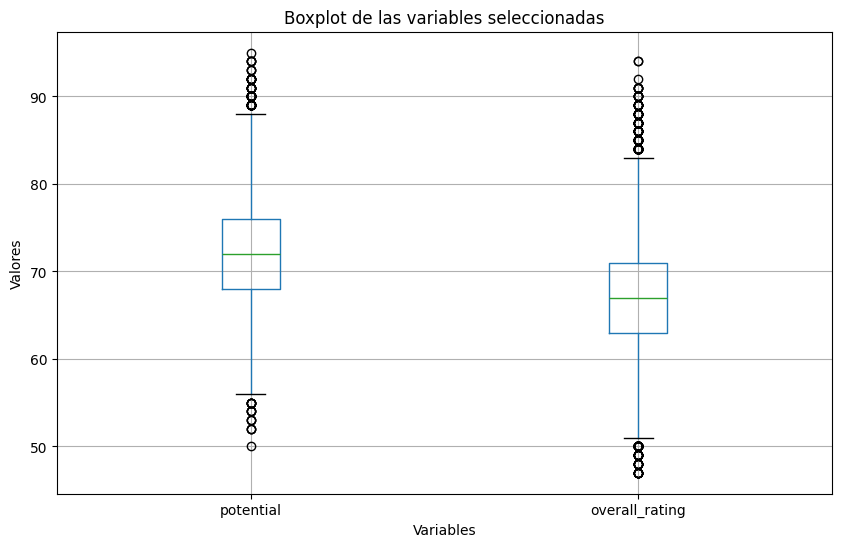

In [48]:
import matplotlib.pyplot as plt

# Supongamos que 'fifa_all' es tu DataFrame y quieres hacer un boxplot de las variables 'age' y 'overall'
variables_seleccionadas = ['potential', 'overall_rating']
fifa_all[variables_seleccionadas].boxplot(figsize=(10, 6))
plt.title('Boxplot de las variables seleccionadas')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()


Adelantandonos un poco a nuestro analisis podemos ver en el grafico que sigue nuestra función de densidad de la variable overal_rating con su histograma, y su media en verde; junto con la representación de una normal tipificada con la media y la desviación típica de nuestra variable. Vemos que se ajusta bastante bien....

[distfit] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


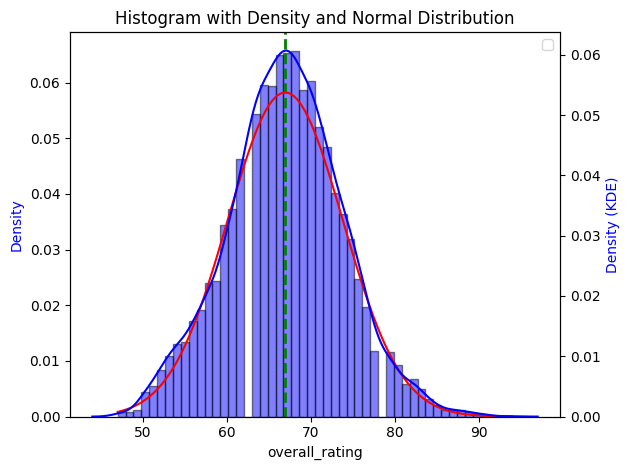

In [49]:
#El siguiente gráfico me parece mucho mejor puesto que superponemos una distribución de probabilidad normal y podemos ver 
# un ajuste bastante aproximado a una normal. 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Calcular la media y la desviación estándar de los datos
mean_overall_rating = fifa_all['overall_rating'].mean()
std_dev_overall_rating = fifa_all['overall_rating'].std()

# Crear puntos para graficar la distribución normal
x = np.linspace(fifa_all['overall_rating'].min(), fifa_all['overall_rating'].max(), 100)
y = norm.pdf(x, mean_overall_rating, std_dev_overall_rating)

# Crear figura y ejes
fig, ax = plt.subplots()

# Generar histograma en el primer eje
ax.hist(fifa_all['overall_rating'], bins=50, density=True, edgecolor='black', color='blue', alpha=0.5)
ax.set_xlabel('overall_rating')
ax.set_ylabel('Density', color='blue')

# Agregar línea vertical para la media
ax.axvline(mean_overall_rating, color='green', linestyle='dashed', linewidth=2, label='Mean')

# Agregar la distribución normal
ax.plot(x, y, color='red', label='Normal Distribution')

# Crear un segundo eje y duplicar el primero
ax2 = ax.twinx()

# Agregar la función de densidad (KDE) en el segundo eje
sns.kdeplot(fifa_all['overall_rating'], color='blue', ax=ax2)
ax2.set_ylabel('Density (KDE)', color='blue')

# Mostrar gráfico
plt.title('Histogram with Density and Normal Distribution')
plt.legend()
plt.tight_layout()
plt.show()



Al igual que con overall_rating, hacemos lo mismo con potential y vemos que aunque menor, tambien podemos ver cierta simetría con la normal.

[distfit] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


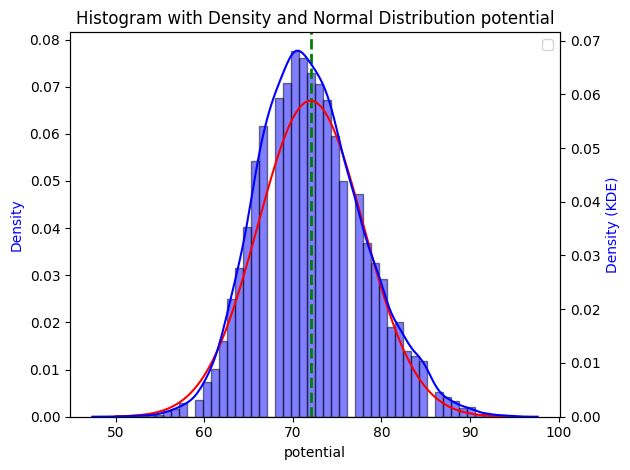

In [51]:
#El siguiente gráfico me parece mucho mejor puesto que superponemos una distribución de probabilidad normal y podemos ver 
# un ajuste bastante aproximado a una normal. 


# Calcular la media y la desviación estándar de los datos
mean_overall_rating = fifa_all['potential'].mean()
std_dev_overall_rating = fifa_all['potential'].std()

# Crear puntos para graficar la distribución normal
x = np.linspace(fifa_all['potential'].min(), fifa_all['potential'].max(), 100)
y = norm.pdf(x, mean_overall_rating, std_dev_overall_rating)

# Crear figura y ejes
fig, ax = plt.subplots()

# Generar histograma en el primer eje
ax.hist(fifa_all['potential'], bins=50, density=True, edgecolor='black', color='blue', alpha=0.5)
ax.set_xlabel('potential')
ax.set_ylabel('Density', color='blue')

# Agregar línea vertical para la media
ax.axvline(mean_overall_rating, color='green', linestyle='dashed', linewidth=2, label='Mean')

# Agregar la distribución normal
ax.plot(x, y, color='red', label='Normal Distribution')

# Crear un segundo eje y duplicar el primero
ax2 = ax.twinx()

# Agregar la función de densidad (KDE) en el segundo eje
sns.kdeplot(fifa_all['potential'], color='blue', ax=ax2)
ax2.set_ylabel('Density (KDE)', color='blue')

# Mostrar gráfico
plt.title('Histogram with Density and Normal Distribution potential')
plt.legend()
plt.tight_layout()
plt.show()

2.2 Medidas descriptivas bivariantes: covarianza y coeficiente de Pearson

In [22]:
fifa_selected_variables=fifa_all[['potential','overall_rating']]
fifa_selected_variables.head(6)
# ESTo lo quitaría

,potential,overall_rating
0,94,94
1,89,88
2,91,88
3,88,88
4,91,88
5,90,88


In [23]:
fifa_selected_variables=fifa_all[['potential','overall_rating']]
fifa_selected_variables.describe()

,potential,overall_rating
count,14496.000000,14496.000000
mean,72.011038,66.955160
std,5.949449,6.849744
min,50.000000,47.000000
25%,68.000000,63.000000
50%,72.000000,67.000000
75%,76.000000,71.000000
max,95.000000,94.000000


Vamos a ver de manera gráfica como se comportan las dos variables:
REVISAR

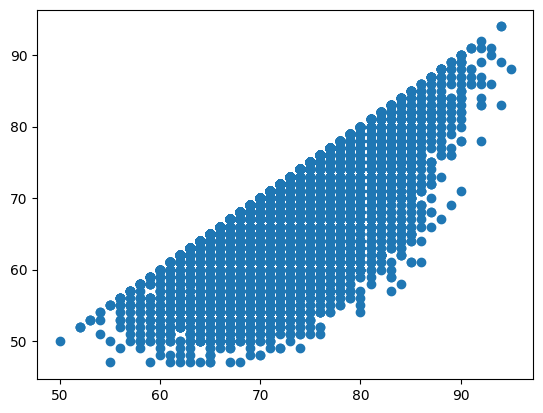

In [25]:
from numpy.lib.function_base import corrcoef

# Faltan los titulos de los ejes y del gráfico

plt.scatter(fifa_all['potential'],fifa_all['overall_rating'])

plt.show()

Vemos una correlación positiva fuerte entre las dos variables, lo que nos hace pensar en una posible correlación entre las dos, pues a medida que una se hace más grande la otra tambien vamos a proceder a calcular su coef de correlación
Calculamos dicho coeficiente y vemos que sí. No hay una correlación perfecta positiva pero vemos que si existe.

In [23]:
corrcoef(fifa_all['potential'],fifa_all['overall_rating'])

array([[1.       , 0.6456477],
       [0.6456477, 1.       ]])

In [29]:
correlation_matrix = fifa_all[['potential','overall_rating','continent','primary_position']].corr(method='spearman')
# Esto nos devuelve lo mismo que el anterior, y no podemo calcular ninguna correlación revisar lo siguiente:

correlation_matrix

,potential,overall_rating
potential,1.000000,0.610264
overall_rating,0.610264,1.000000


Si tus variables categóricas pueden tomar más de dos valores, entonces necesitarás considerar una técnica diferente para calcular la correlación entre ellas. Una opción sería utilizar el coeficiente de contingencia (también conocido como coeficiente de asociación de Pearson para variables categóricas), que es una medida de asociación entre dos variables categóricas.

Puedes calcular el coeficiente de contingencia utilizando la función contingency_matrix de la biblioteca scipy.stats. Aquí te muestro un ejemplo de cómo hacerlo:

python
Copy code
from scipy.stats import chi2_contingency

# Suponiendo que 'variable1' y 'variable2' son tus variables categóricas
contingency_table = pd.crosstab(fifa_all['variable1'], fifa_all['variable2'])

# Calcula el coeficiente de contingencia
chi2, _, _, _ = chi2_contingency(contingency_table)

# Calcula el coeficiente de correlación de Pearson a partir del chi-cuadrado
n = contingency_table.sum().sum()
pearson_corr = np.sqrt(chi2 / (n + chi2))

print("Coeficiente de correlación de contingencia:", pearson_corr)
Este código calculará el coeficiente de contingencia entre las variables categóricas 'variable1' y 'variable2'. El coeficiente de contingencia oscila entre 0 y 1, donde 0 indica independencia y 1 indica una asociación completa entre las variables categóricas.
El coeficiente de correlación de Pearson es una medida de la relación lineal entre dos variables continuas. Como tal, no es apropiado calcularlo directamente para variables categóricas. Sin embargo, hay formas de calcular una medida de asociación entre variables categóricas.

Para variables categóricas, se pueden utilizar otras medidas de asociación, como el coeficiente de contingencia (C), el coeficiente de contingencia de Pearson (φ), el coeficiente de correlación de Spearman (ρ), el coeficiente de correlación de Kendall (τ), entre otros.

Coeficiente de contingencia (C): Es una medida de la fuerza de la asociación entre dos variables categóricas en una tabla de contingencia. Varía de 0 a 1, donde 0 indica ninguna asociación y 1 indica asociación perfecta.

Coeficiente de contingencia de Pearson (φ): Similar al coeficiente de contingencia, pero normalizado para que varíe de -1 a 1, donde 0 indica independencia y -1 o 1 indican una asociación perfecta.

Coeficiente de correlación de Spearman (ρ): Calcula la correlación entre las clasificaciones de dos variables. Es una medida de la relación monótona entre dos variables, incluso si no son continuas.

Coeficiente de correlación de Kendall (τ): Similar al coeficiente de correlación de Spearman, pero mide la concordancia entre los órdenes de clasificación de dos variables.

Estas medidas son más adecuadas para variables categóricas, ya que no hacen suposiciones sobre la distribución de los datos y pueden capturar diferentes tipos de relaciones, incluidas las no lineales.

En resumen, para variables categóricas, es mejor utilizar medidas de asociación diseñadas específicamente para este tipo de datos en lugar del coeficiente de correlación de Pearson, que está destinado a variables continuas.

3. Comprobación de la normalidad de alguna/s variable/s del conjunto de datos.

Tras las visualizaciones anteriores de nuestras variables continuas y las apariencias de normalidad vamos, mediante la librería distfit a analizar matematicamente si nuestras primeras asumciones de normalidad son correctas o qué otras posibles distribucuónes de probabilidad se ajustarían mejor a 'overall_rating' y 'potential':

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.034634] [loc=66.955 scale=6.850]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0767882] [loc=47.000 scale=19.955]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.0767882] [loc=-4294967249.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.12 sec] [RSS: 0.0365272] [loc=66.558 scale=5.831]
[distfit] >INFO> [t         ] [1.51 sec] [RSS: 0.0345666] [loc=66.952 scale=6.700]
[distfit] >INFO> [genextreme] [0.56 sec] [RSS: 0.0353982] [loc=64.332 scale=6.780]
[distfit] >INFO> [gamma     ] [0.36 sec] [RSS: 0.0346764] [loc=-323.808 scale=0.120]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 0.034675] [loc=-532.976 scale=599.892]
[distfit] >INFO> [beta      ] [0.59 sec] [RSS: 0.0347021] [loc=-191.726 scale=857862.661]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0660605] [loc=47.000 scale=47.000]
[distfit] >INFO> [loggamma  ] [0.14 sec] [RSS: 0.0346148] [loc=-1340.990 scale=206.809]
[di

          name     score           loc          scale  \
0            t  0.034567     66.951764       6.700384   
1     loggamma  0.034615  -1340.989679     206.808831   
2         norm  0.034634      66.95516       6.849508   
3      lognorm  0.034675   -532.976158     599.892221   
4        gamma  0.034676   -323.808283       0.120062   
5         beta  0.034702   -191.725924  857862.660551   
6   genextreme  0.035398     64.331863       6.779752   
7     dweibull  0.036527     66.558092       5.831256   
8      uniform  0.066061          47.0           47.0   
9       pareto  0.076788 -4294967249.0   4294967296.0   
10       expon  0.076788          47.0       19.95516   

                                        arg  \
0                       (46.2785791710783,)   
1                       (905.486319525809,)   
2                                        ()   
3                   (0.011416715628033852,)   
4                      (3254.664230223365,)   
5   (1424.9130353440576, 4723996.

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nt(df=46.2786, loc=66.9518, scale=6.70038)'}, xlabel='Values', ylabel='Frequency'>)

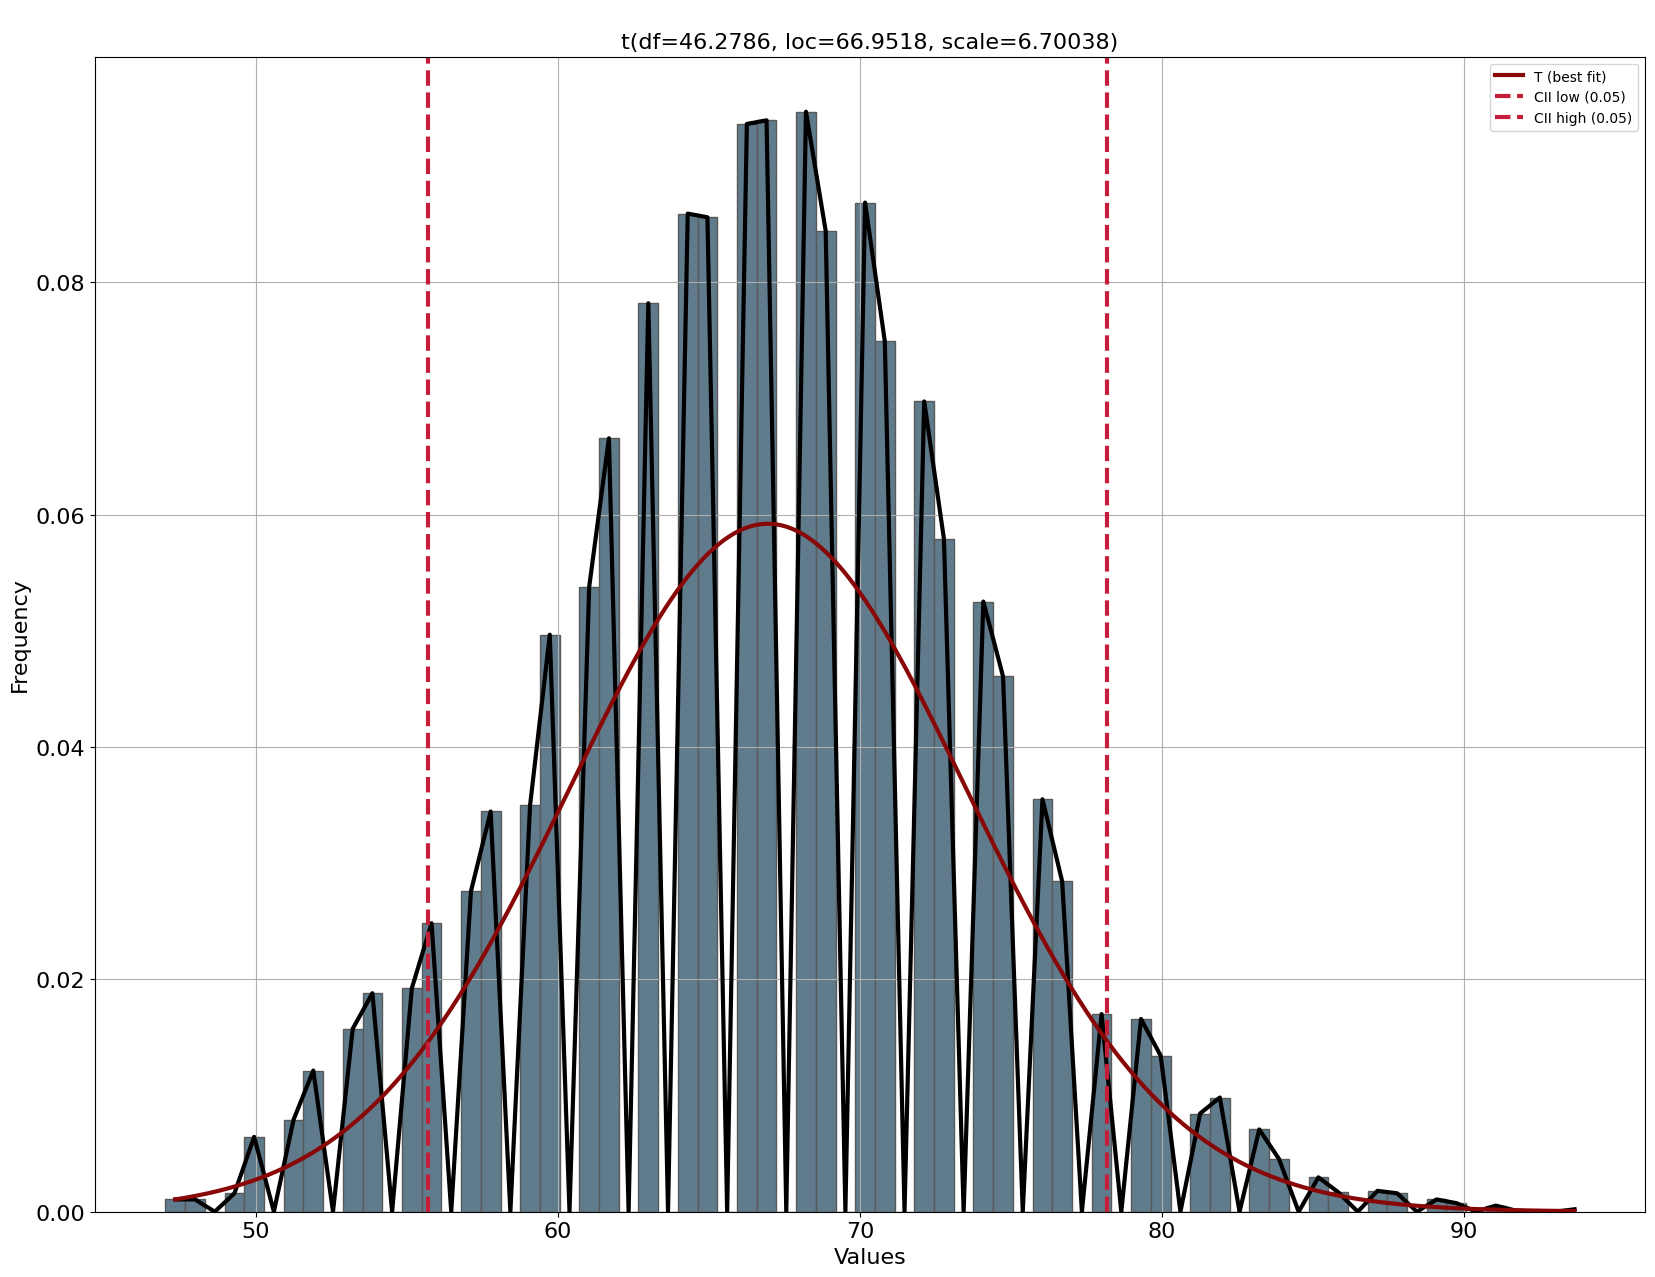

In [30]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your data
dist.fit_transform(fifa_all["overall_rating"])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0396767] [loc=72.011 scale=5.949]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.094536] [loc=50.000 scale=22.011]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.094536] [loc=-4294967246.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.14 sec] [RSS: 0.0412437] [loc=71.556 scale=5.122]
[distfit] >INFO> [t         ] [1.39 sec] [RSS: 0.0396212] [loc=71.989 scale=5.876]
[distfit] >INFO> [genextreme] [0.77 sec] [RSS: 0.038989] [loc=69.673 scale=5.622]
[distfit] >INFO> [gamma     ] [0.11 sec] [RSS: 0.0389687] [loc=32.645 scale=0.898]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 0.0389467] [loc=15.163 scale=56.540]
[distfit] >INFO> [beta      ] [0.60 sec] [RSS: 0.0389795] [loc=34.839 scale=533.514]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.0792524] [loc=50.000 scale=45.000]
[distfit] >INFO> [loggamma  ] [0.19 sec] [RSS: 0.0398063] [loc=-1688.489 scale=238.960]
[distfit] >INFO

          name     score           loc         scale  \
0      lognorm  0.038947     15.162712     56.539606   
1        gamma  0.038969     32.645281      0.898122   
2         beta   0.03898     34.839015    533.513505   
3   genextreme  0.038989     69.673379       5.62243   
4            t  0.039621     71.988983      5.876116   
5         norm  0.039677     72.011038      5.949244   
6     loggamma  0.039806  -1688.489182    238.959605   
7     dweibull  0.041244     71.555988       5.12178   
8      uniform  0.079252          50.0          45.0   
9       pareto  0.094536 -4294967246.0  4294967296.0   
10       expon  0.094536          50.0     22.011038   

                                        arg  \
0                    (0.10435444637460911,)   
1                      (43.83118967823402,)   
2   (36.32505434751738, 485.01545870933137)   
3                    (0.18823730277704265,)   
4                      (81.78550501050199,)   
5                                        ()  

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nlognorm(s=0.104354, loc=15.1627, scale=56.5396)'}, xlabel='Values', ylabel='Frequency'>)

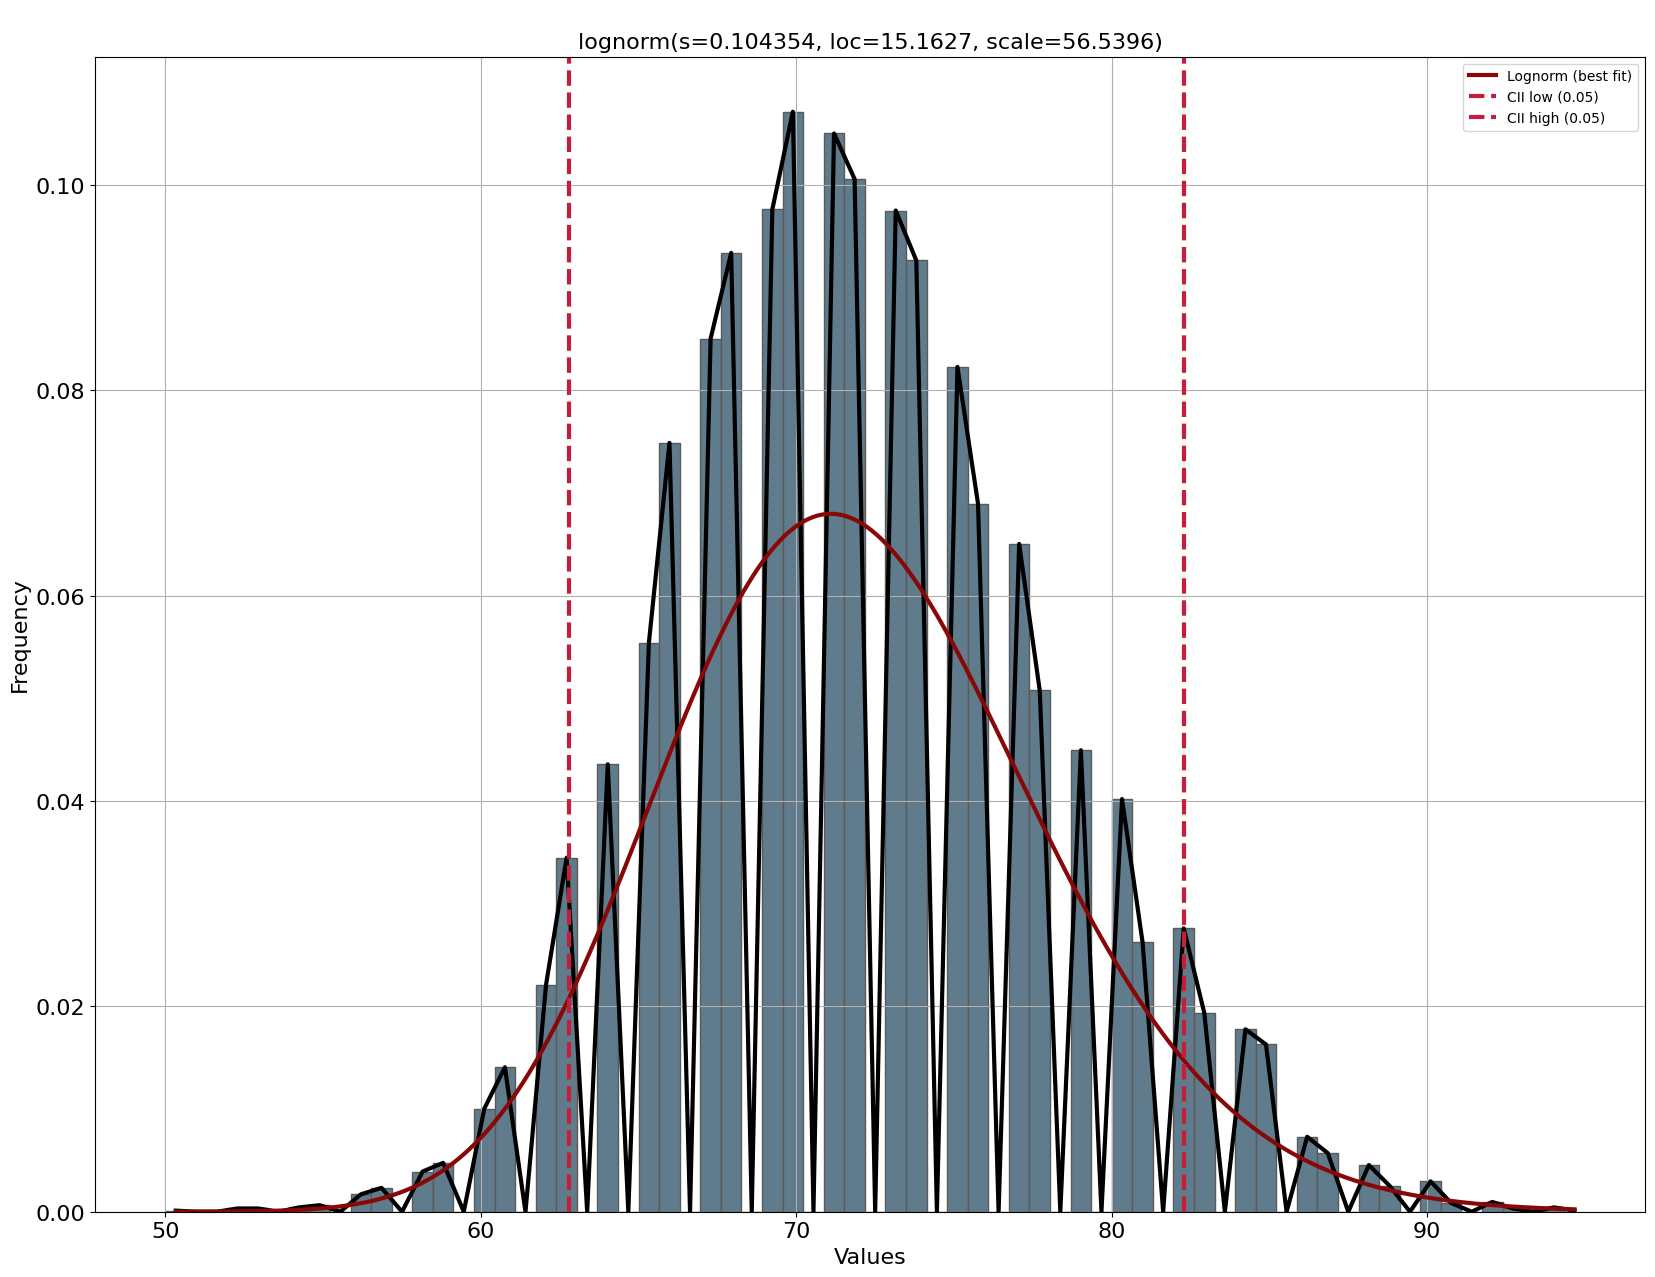

In [31]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your data
dist.fit_transform(fifa_all["potential"])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()


Sí, es posible transformar una variable que sigue una distribución t de Student para que se aproxime a una distribución normal. Esto se puede lograr utilizando la transformación de Box-Cox o la transformación de Yeo-Johnson.

La transformación de Box-Cox es adecuada para variables que son estrictamente positivas, mientras que la transformación de Yeo-Johnson puede manejar variables que contienen valores negativos.

Puedes aplicar estas transformaciones utilizando la función correspondiente de la biblioteca scipy.stats. Aquí tienes un ejemplo de cómo hacerlo:

python
Copy code
from scipy.stats import boxcox

# Suponiendo que 'variable_t_student' es la variable que sigue una distribución t de Student
transformed_variable, lambda_value = boxcox(df['variable_t_student'])

# La variable 'transformed_variable' ahora sigue una distribución normal
Esta transformación ajustará automáticamente la variable para que se aproxime a una distribución normal. Sin embargo, es importante tener en cuenta que estas transformaciones pueden no ser adecuadas en todos los casos, especialmente si los datos no cumplen con las suposiciones subyacentes de las distribuciones. Por lo tanto, siempre es recomendable realizar pruebas y validaciones adicionales después de realizar la transformación.

Transformamos la variable potential con box cox para ajustarla a una normal y lo mostramos en un gráfico. Podemos hacer lo mismo para la otra variable.

In [56]:
transformed_variable, lambda_value = boxcox(fifa_all['potential'])
transformed_variable2, lambda_value2 = boxcox(fifa_all['overall_rating'])

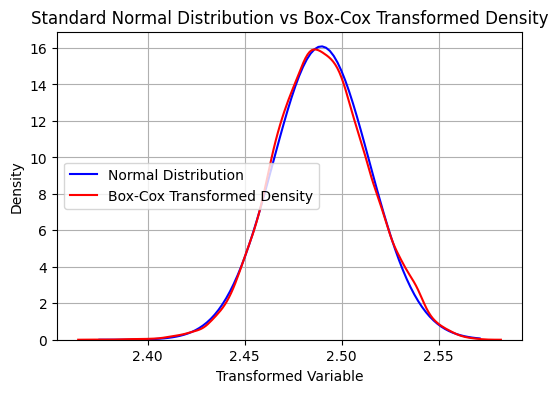

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, norm

# Supongamos que tienes tu DataFrame 'fifa_all' y has calculado 'transformed_variable' usando Box-Cox

# Calcular la media y la desviación estándar de la variable transformada
mean_transformed = transformed_variable.mean()
std_dev_transformed = transformed_variable.std()

# Calcular los límites del rango de la variable transformada
min_value_transformed = transformed_variable.min()
max_value_transformed = transformed_variable.max()

# Crear puntos para graficar la distribución normal tipificada
x_normal = np.linspace(min_value_transformed, max_value_transformed, 100)
y_normal = norm.pdf(x_normal, loc=mean_transformed, scale=std_dev_transformed)

# Crear figura y ejes
plt.figure(figsize=(6,4))

# Graficar la densidad de la distribución normal tipificada
plt.plot(x_normal, y_normal, color='blue', label='Normal Distribution')

# Graficar la densidad de la variable transformada utilizando Box-Cox
sns.kdeplot(transformed_variable, color='red', label='Box-Cox Transformed Density')

plt.title('Standard Normal Distribution vs Box-Cox Transformed Density')
plt.xlabel('Transformed Variable')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()




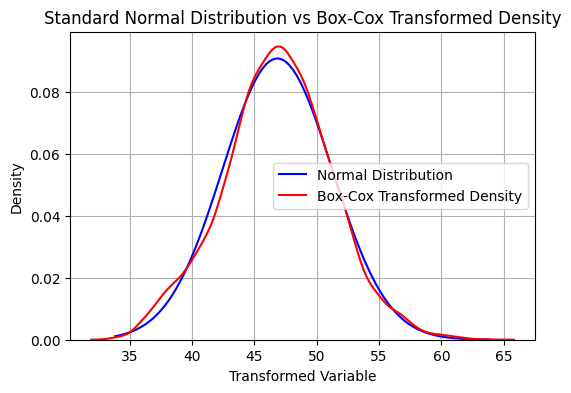

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, norm

# Supongamos que tienes tu DataFrame 'fifa_all' y has calculado 'transformed_variable' usando Box-Cox

# Calcular la media y la desviación estándar de la variable transformada
mean_transformed2 = transformed_variable2.mean()
std_dev_transformed2 = transformed_variable2.std()

# Calcular los límites del rango de la variable transformada
min_value_transformed2 = transformed_variable2.min()
max_value_transformed2 = transformed_variable2.max()

# Crear puntos para graficar la distribución normal tipificada
x_normal = np.linspace(min_value_transformed2, max_value_transformed2, 100)
y_normal = norm.pdf(x_normal, loc=mean_transformed2, scale=std_dev_transformed2)

# Crear figura y ejes
plt.figure(figsize=(6, 4))

# Graficar la densidad de la distribución normal tipificada
plt.plot(x_normal, y_normal, color='blue', label='Normal Distribution')

# Graficar la densidad de la variable transformada utilizando Box-Cox
sns.kdeplot(transformed_variable2, color='red', label='Box-Cox Transformed Density')

plt.title('Standard Normal Distribution vs Box-Cox Transformed Density')
plt.xlabel('Transformed Variable')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

4. Estimación puntual y por intervalos de los parámetros poblacionales de
algunas variables.


- Intervalos de confianza en la estimación de parametros. Z=sigma/raiz2n

- Creacion de intervalos de confianza tanto con la normal como con la t


In [58]:
# Estimación de los intervalos de confianza de la media muestral con una probabilidad del 95 %
# Cogemos la t de estudent porque no conocemos la desviación típica poblacional
import scipy.stats

size = fifa_all['potential'].count()

sample_mean = fifa_all['potential'].mean()

t_critical = stats.t.ppf(q = 0.975, df=199)  # Get the t-critical value*

print("t-critical value:")                  # Check the t-critical value
print(t_critical)

pop_stdev = fifa_all['potential'].std()  # Get the population standard deviation

margin_of_error = t_critical * (pop_stdev/math.sqrt(size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)
print(f'Media muestral de potential: {sample_mean}')
print("Confidence interval:")
print(confidence_interval)

t-critical value:
1.971956544249395
Media muestral de potential: 72.01103752759381
Confidence interval:
(71.91359467020723, 72.1084803849804)


In [67]:
# Revisar porque los he hecho con una muestra del dataset potential
sample_size = 200

intervals = []
sample_means = []

for sample in range(25):
    sample = np.random.choice(fifa_all['potential'], size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)

    t_critical = stats.t.ppf(q = 0.975,df=199)  # Get the z-critical value*
    
    pop_stdev = fifa_all['potential'].std()  # Get the population standard deviation

    stats.norm.ppf(q = 0.025)

    margin_of_error = t_critical * (pop_stdev/math.sqrt(sample_size))

    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)

    intervals.append(confidence_interval)

    # print(sample_means)
    # print(intervals)

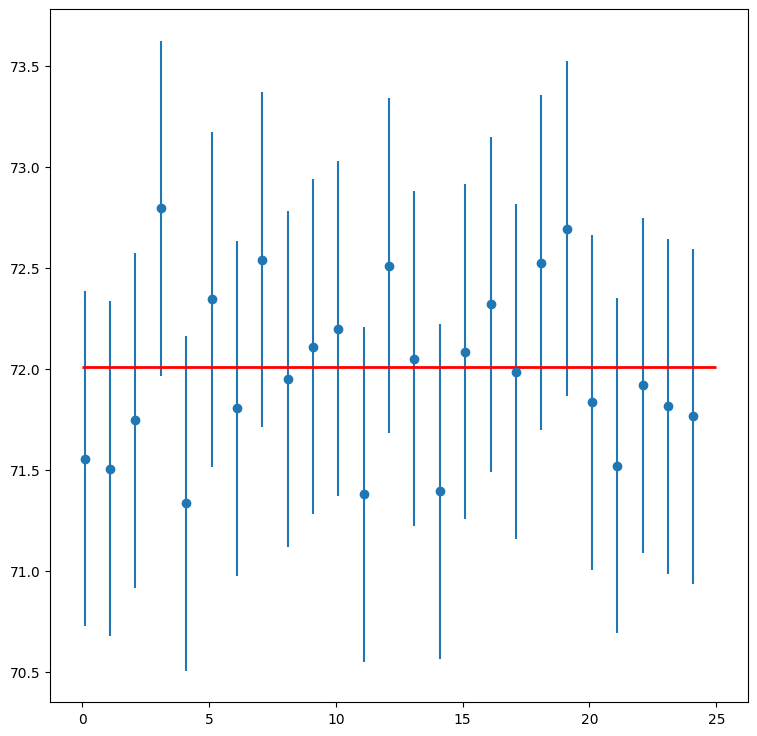

In [60]:
plt.figure(figsize=(9,9))

plt.errorbar(x=np.arange(0.1, 25, 1),
             y=sample_means,
             yerr=[(bot-top)/2 for top,bot in intervals],
             fmt='o')
potential_overall_mean=fifa_all['potential'].mean()
plt.hlines(xmin=0, xmax=25,
           y=potential_overall_mean,
           linewidth=2.0,
           color="red")

In [62]:
stats.t.interval(confidence = 0.95,              # Confidence level
                 df= 24,                    # Degrees of freedom,revisarlos,son los del ejemplo
                 loc = sample_mean,         # Sample mean
                 scale = pop_stdev)             # Standard deviation estimate

(59.48594035525071, 84.0440596447493)

Faltaría crear un gráfico como el anterior para la otra variable

5. Realización de contrastes de hipótesis oportunos para realizar inferencia con
los datos
- Normalidad de las muestras o población: esta hecho más arriva

- Media

- Varianza


6. Realización de ANOVA (cond. de aplicabilidad, ANOVA, post-hoc) para
obtener conclusiones de los datos

- Ya tenemos la anova de ayer y esta genial, ver otras posibilidades.

- Analisis de homocedasticidad y justificación.

- Justificación del uso de la ANOVA

Puede utilizarse la f de snedecor para hacer un contraste de hipótesis de homocedasticidad de varianzas entre tres variables?
ChatGPT
Sí, es posible utilizar la distribución F de Snedecor para realizar un contraste de hipótesis de homocedasticidad (igualdad de varianzas) entre tres variables. Este tipo de prueba se conoce como prueba de igualdad de varianzas o prueba de homogeneidad de varianzas.

La prueba de igualdad de varianzas se puede realizar comparando las varianzas muestrales de las tres variables. Si las varianzas son significativamente diferentes entre las variables, esto podría indicar que las varianzas poblacionales también son diferentes.

El procedimiento básico sería el siguiente:

Obtener muestras de las tres variables que se desean comparar.
Calcular las varianzas muestrales de las tres muestras.
Calcular la estadística de prueba F, que es la razón entre la mayor varianza muestral y la menor varianza muestral.
Utilizar la distribución F de Snedecor para determinar el valor p asociado con la estadística de prueba F.
Comparar el valor p con un nivel de significancia predeterminado (por ejemplo, 0.05). Si el valor p es menor que el nivel de significancia, se rechaza la hipótesis nula de igualdad de varianzas, lo que indica que al menos una de las varianzas poblacionales es significativamente diferente de las demás.
Es importante tener en cuenta que la prueba de igualdad de varianzas asume que las muestras son independientes y que cada muestra sigue una distribución normal en la población. Si estas suposiciones no se cumplen, es posible que los resultados de la prueba no sean válidos.

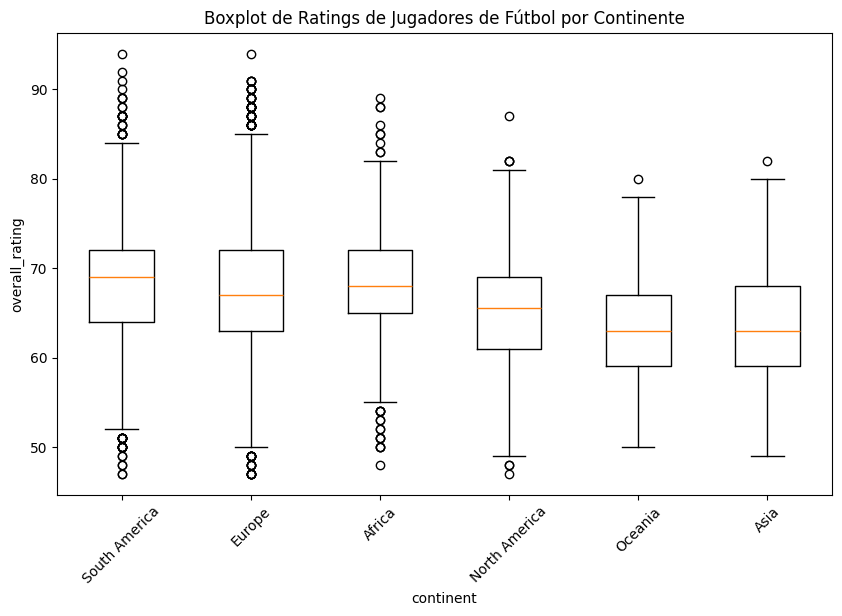

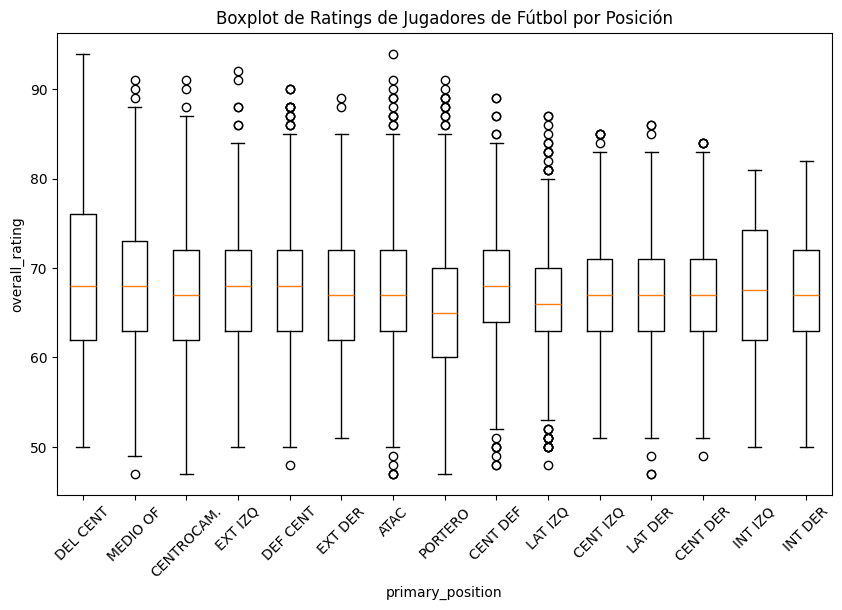

In [ ]:
# Boxplot by continent over overall_rating
fifa_all = fifa_all.dropna(subset=['continent'])
plt.figure(figsize=(10, 6))
plt.boxplot([fifa_all[fifa_all['continent'] == nationality]['overall_rating'] for nationality in fifa_all['continent'].unique()],
            labels=fifa_all['continent'].unique())
plt.xlabel('continent')
plt.ylabel('overall_rating')
plt.title('Boxplot de Ratings de Jugadores de Fútbol por Continente')
plt.xticks(rotation=45)
plt.show()

# Boxplot by position over overall_rating
fifa_all = fifa_all.dropna(subset=['primary_position'])
plt.figure(figsize=(10, 6))
plt.boxplot([fifa_all[fifa_all['primary_position'] == nationality]['overall_rating'] for nationality in fifa_all['primary_position'].unique()],
            labels=fifa_all['primary_position'].unique())
plt.xlabel('primary_position')
plt.ylabel('overall_rating')
plt.title('Boxplot de Ratings de Jugadores de Fútbol por Posición')
plt.xticks(rotation=45)
plt.show()

In [63]:
# ANOVA continent vs overall_rating
model = ols('overall_rating ~ continent',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

# ANOVA continent vs overall_rating
model = ols('overall_rating ~ primary_position',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                  sum_sq       df           F         PR(>F)
continent   30811.257123      5.0  137.523224  5.932954e-143
Residual   649279.596906  14490.0         NaN            NaN
                         sum_sq       df          F        PR(>F)
primary_position    9289.880526     14.0  14.324747  7.805218e-35
Residual          670800.973502  14481.0        NaN           NaN


In [64]:
# Agrupar los datos por continente y calcular la varianza de 'overall_rating' para cada grupo
grouped = fifa_all.groupby('continent')['overall_rating'].apply(list)

# Convertir los datos en una lista de listas
data = [group for group in grouped]

# Aplicar la prueba de Levene desempaquetando los datos
statistic, p_value = levene(*data)

# Imprimir los resultados
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)

# Agrupar los datos por posición y calcular la varianza de 'overall_rating' para cada grupo
grouped = fifa_all.groupby('primary_position')['overall_rating'].apply(list)

# Convertir los datos en una lista de listas
data = [group for group in grouped]

# Aplicar la prueba de Levene desempaquetando los datos
statistic, p_value = levene(*data)

# Imprimir los resultados
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)

Estadístico de Levene: 11.620993408965496
Valor p: 3.153276520085977e-11
Estadístico de Levene: 15.899161538525572
Valor p: 2.7550612726748132e-39


7. Cosas que podríamos añadir y que he visto en los apuntes:

- Potencia de lo test utilizados

- Representación de los errores tipo I y II

- Muestras pareadas.

- Plot de las diferentes muestras y sus intérvalos de confianza.

- Revisar exponencial

- Pensar en si podemos convertir alguna variable en una binomial.

- Investigar cualquier otra via, posibilidad de extrapolar a una posible población más grande los resultados de nuestra población.



tips:
Sumario a la izquierda
Objetivos: generales y especificos
Materiales dataset, metodología, todos las pruebas que se van a realizar y el objetivo de ellas
Resultados, analisis y librerias
Definición de variables: clining del dataset
descriptiva variante y bivariante una de cada tipo de variable
Comentar relaciones causa efecto pero no categorizando los datos
Explicar los gráficos
Diferentes tipos de gráficos
Comentar los resultados de cada ejecución
Estudio de normalidad: hombres, mujeres y todos
Contrastes de hipotesis
Inferencia estadistica, puntual y por intervalos
Contrastes de hipotesis
Anova, condiciones de aplicabilidad, etc..
Conclusiones, lo más importante

Variable aleatoria chi-cuadrado: 9.000000000000002


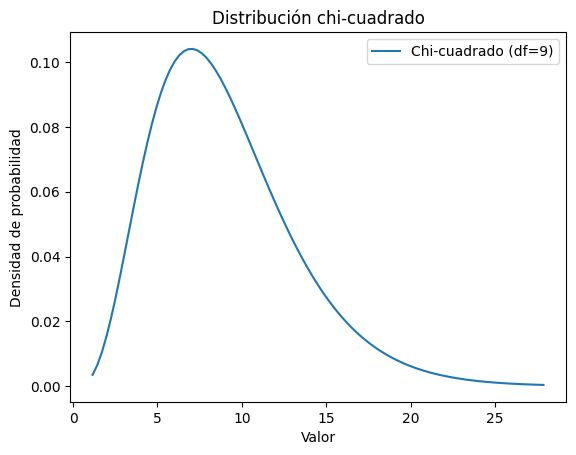

In [ ]:
# SOLAMENTE MENCIONAR SI NO HACEMOS NADA CON LA CHI2 PORQUE

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Generar una muestra del número de errores en 10 días (simulación)
np.random.seed(42)  # Para reproducibilidad
errores_por_dia = np.random.poisson(lam=5, size=10)  # Distribución de Poisson con una tasa media de 5 errores por día

# Calcular la media y la desviación estándar de la muestra
media_muestra = np.mean(errores_por_dia)
desviacion_muestra = np.std(errores_por_dia, ddof=1)  # Usar ddof=1 para calcular la desviación estándar muestral (n-1)

# Calcular la variable aleatoria chi-cuadrado
grados_libertad = len(errores_por_dia) - 1
chi2_variable = np.sum(((errores_por_dia - media_muestra) / desviacion_muestra) ** 2)

# Imprimir la variable aleatoria chi-cuadrado
print("Variable aleatoria chi-cuadrado:", chi2_variable)

# Generar puntos para graficar la distribución chi-cuadrado
x = np.linspace(chi2.ppf(0.001, df=grados_libertad), chi2.ppf(0.999, df=grados_libertad), 100)
pdf_chi2 = chi2.pdf(x, df=grados_libertad)

# Graficar la distribución chi-cuadrado
plt.plot(x, pdf_chi2, label='Chi-cuadrado (df=9)')
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución chi-cuadrado')
plt.legend()
plt.show()



Estadística de prueba F: 0.36496948359340925
Valor p: 0.9958207740581527


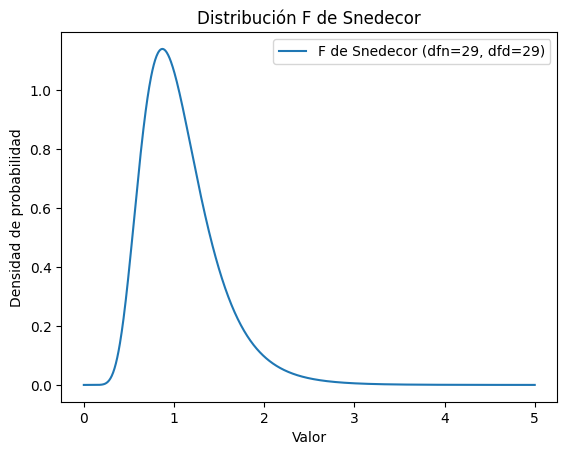

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f

# Simular muestras aleatorias de dos poblaciones
np.random.seed(42)
muestra_1 = np.random.normal(loc=10, scale=5, size=30)  # Muestra de la población 1
muestra_2 = np.random.normal(loc=10, scale=8, size=30)  # Muestra de la población 2

# Calcular las varianzas muestrales
varianza_muestra_1 = np.var(muestra_1, ddof=1)  # Usar ddof=1 para calcular la varianza muestral (n-1)
varianza_muestra_2 = np.var(muestra_2, ddof=1)

# Calcular la estadística de prueba F
f_statistic = varianza_muestra_1 / varianza_muestra_2

# Calcular el valor p
dfn = len(muestra_1) - 1  # Grados de libertad del numerador
dfd = len(muestra_2) - 1  # Grados de libertad del denominador
p_value = 1 - f.cdf(f_statistic, dfn, dfd)

# Imprimir el valor p y la estadística de prueba
print("Estadística de prueba F:", f_statistic)
print("Valor p:", p_value)

# Graficar la distribución F de Snedecor
x = np.linspace(0, 5, 1000)
pdf_f = f.pdf(x, dfn, dfd)
plt.plot(x, pdf_f, label='F de Snedecor (dfn={}, dfd={})'.format(dfn, dfd))
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución F de Snedecor')
plt.legend()
plt.show()
